In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torchvision.datasets

#### Get data

In [5]:
MNIST_TRAIN = torchvision.datasets.MNIST(root='./', train=True, download=True)
MNIST_TEST = torchvision.datasets.MNIST(root='./', train=False, download=True)

In [6]:
X_train, y_train = MNIST_TRAIN.data, MNIST_TRAIN.targets

In [7]:
X_test, y_test = MNIST_TEST.data, MNIST_TEST.targets

In [8]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

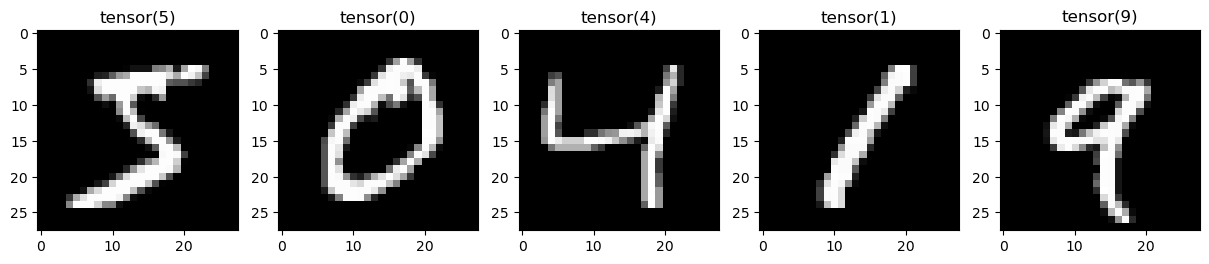

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(15,4))
for i in range(5):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].title.set_text(y_train[i])
plt.show();

In [10]:
X_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

#### Define base FC model (without conv)

In [11]:
class FcModel(nn.Module):
    def __init__(self, num_features = 28 * 28, hidden = 200, num_classes = 10):
        super().__init__()
        self.fc1 = nn.Linear(num_features, hidden)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, num_classes)
    
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    

#### Make dataloader

In [12]:
from torch.utils.data import DataLoader, TensorDataset

In [13]:
X_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [17]:
X_train, X_test = X_train.to(torch.float16), X_test.to(torch.float16)
y_train, y_test = y_train.to(torch.uint8), y_test.to(torch.uint8)


In [32]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, pin_memory=True, shuffle=True, num_workers=4)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, pin_memory=True, shuffle=True, num_workers=4)

#### Pre-train details

In [33]:
def acc_fn(y_true, y_preds):
    if y_true.shape != y_preds.shape:
        return ValueError("Wrong shapes y_true and y_preds")
    return torch.sum(y_true == y_preds) / len(y_true)

In [ ]:
def train_func(model_class, tr_l, ts_l, loss_fn, acc_fn, device, epochs=100, lr = 1e-4):
    
    train_loss_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    model = model_class().half().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.7)
    
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        
        for X, y in tr_l:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(tr_l)
        train_loss_hist.append(train_loss)

        
        if epoch % (epochs // 10) == 0:
            
            model.eval()
            test_loss = 0
            test_acc = 0
            
            with torch.no_grad():
                for X, y in ts_l:
                    X, y = X.to(device), y.to(device)
                    preds = model(X)
                    test_loss += loss_fn(preds, y).item()
                    test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()
            
            test_loss /= len(ts_l)
            test_acc /= len(ts_l)
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
            
            print(
                f"Epoch: {epoch}\ttrain loss: {loss}\ttest loss:{test_loss}\ttest acc:{test_acc}"
            )
    return (model, train_loss_hist, test_loss_hist, test_acc_hist)

In [91]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
trained_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(FcModel, train_loader, 
                                                            test_loader, loss_fn, 
                                                            acc_fn, device, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	train loss: 0.468994140625	test loss:0.3171981618374209	test acc:0.9107990506329114
Epoch: 1	train loss: 0.048583984375	test loss:0.25069089479084256	test acc:0.9254351265822784
Epoch: 2	train loss: 0.07769775390625	test loss:0.21898641465585442	test acc:0.9356210443037974
Epoch: 3	train loss: 0.1185302734375	test loss:0.1990302363528481	test acc:0.9385878164556962
Epoch: 4	train loss: 0.13623046875	test loss:0.18397850326344936	test acc:0.9451147151898734
Epoch: 5	train loss: 0.359375	test loss:0.17725814143313637	test acc:0.946993670886076
Epoch: 6	train loss: 0.181396484375	test loss:0.16813022275514242	test acc:0.9482792721518988
Epoch: 7	train loss: 0.09368896484375	test loss:0.16076389747329906	test acc:0.9493670886075949
Epoch: 8	train loss: 0.07958984375	test loss:0.15349240846271756	test acc:0.9517405063291139
Epoch: 9	train loss: 0.07196044921875	test loss:0.1524013084701345	test acc:0.952432753164557


In [104]:
def plot_train_func(train_loss_hist, test_loss_hist, test_acc_hist):
    d = {
        0 : train_loss_hist,
        1 : test_loss_hist,
        2 : test_acc_hist
	}
    names = {
        0 : "Train loss",
        1 : "Test loss",
        2 : "Test accuracy"
    }
    fig, ax = plt.subplots(1, 3, figsize=(15,4))
    for i in range(3):
        ax[i].plot(d[i])
        ax[i].grid()
        ax[i].set_title(names[i])
    plt.show();

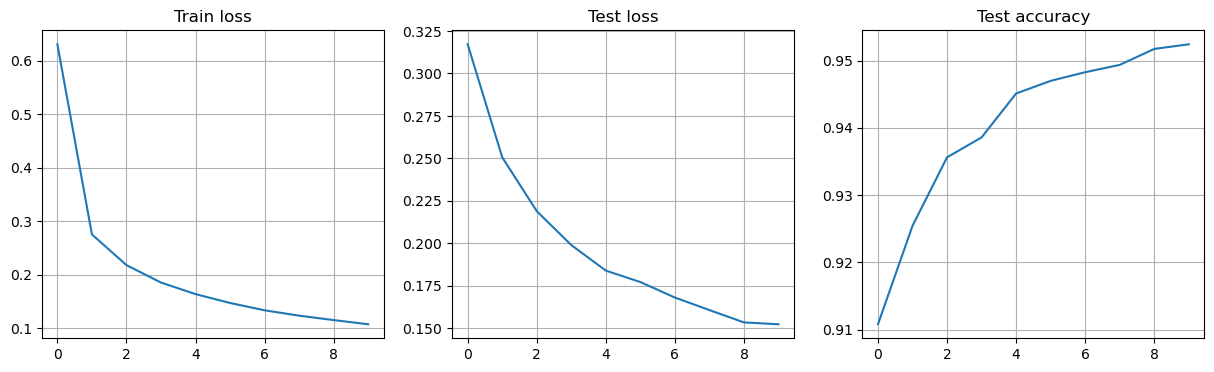

In [105]:
plot_train_func(tr_loss_hist, ts_loss_hist, ts_acc_hist)

In [106]:
import gc
gc.collect()

torch.mps.empty_cache()

#### Now let's try Conv net

In [140]:
class ConvNet(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10, hidden = 384):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        
        
        self.seq1 = nn.Sequential(
			nn.Conv2d(in_channels, 6, 3, padding=1), # 28 -> 28
            self.relu,
            nn.BatchNorm2d(6),
			nn.MaxPool2d(2, 2) # 28 -> 14
		)
        
        self.seq2 = nn.Sequential(
			nn.Conv2d(6, 16, 3, padding=1), # 14 -> 14
            self.relu,
            nn.BatchNorm2d(16),
			nn.MaxPool2d(2, 2) # 14 -> 7
		)
        self.fc1 = nn.Linear(7 * 7 * 16, hidden)
        self.bn = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(dim = 1)
        x = self.seq1(x)
        x = self.seq2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.bn(x)
        x = self.fc2(x)
        return x

In [ ]:
model, conv_tr_loss_hist, conv_ts_loss_hist, conv_ts_acc_hist = train_func(
    ConvNet, train_loader, test_loader, loss_fn, acc_fn, device, 10, 3e-3
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	train loss: 0.044769287109375	test loss:0.08433300935769383	test acc:0.9754746835443038
Epoch: 1	train loss: 0.15283203125	test loss:0.062009400959256326	test acc:0.9818037974683544
Epoch: 2	train loss: 0.04974365234375	test loss:0.04959840412381329	test acc:0.985067246835443
Epoch: 3	train loss: 0.17041015625	test loss:0.04597337940071203	test acc:0.9851661392405063
Epoch: 4	train loss: 0.020599365234375	test loss:0.04350628430330301	test acc:0.986056170886076
Epoch: 5	train loss: 0.0249786376953125	test loss:0.03874938095672221	test acc:0.9873417721518988
Epoch: 6	train loss: 0.16552734375	test loss:0.040117336224906056	test acc:0.9871439873417721
Epoch: 7	train loss: 0.0732421875	test loss:0.03695437274401701	test acc:0.9883306962025317
Epoch: 8	train loss: 0.056854248046875	test loss:0.03675330439700356	test acc:0.9873417721518988
Epoch: 9	train loss: 0.00843048095703125	test loss:0.036391439317147944	test acc:0.9883306962025317


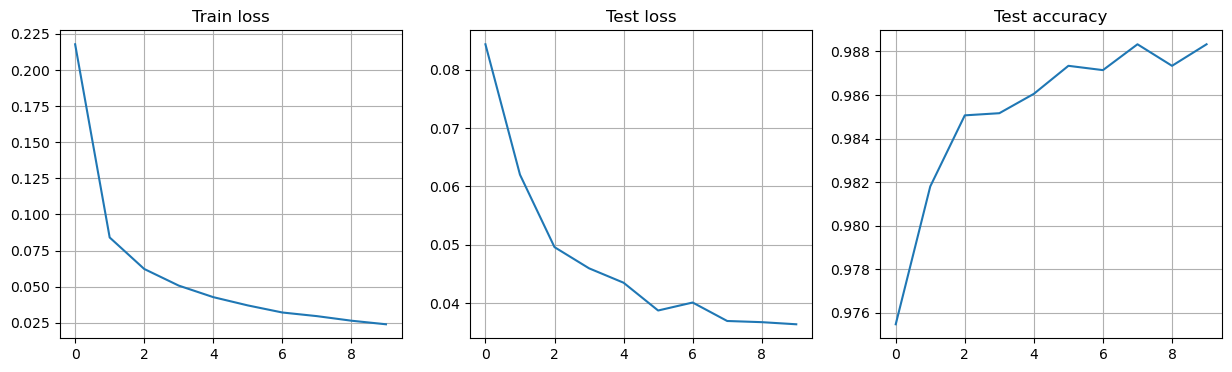

In [143]:
plot_train_func(conv_tr_loss_hist, conv_ts_loss_hist, conv_ts_acc_hist)

#### As we can observe, ConvNet trained faster on our data and showed much better accuracy compared to the full-connected neural network